## General fits for MBI type data

In [2]:
import sys
import numpy as np

sys.path.append(r'D:/measuring')
sys.path.append(r'D:/measuring/analysis')

from analysis.scripts.mbi import mbi_data_general_fits as fits; reload(fits)
%matplotlib inline


d:\measuring\data
reloaded
reloaded
reloaded


2
starting fit.fit1d
Converged with chi squared  0.0117142104892
degrees of freedom, dof  10
RMS of residuals (i.e. sqrt(chisq/dof))  0.0342260288219
Reduced chisq (i.e. variance of residuals)  0.00117142104892

fitted parameters at minimum, with 68% C.I.:
 0 A             -0.376349 +/-   0.017322
 1 T              0.153986 +/-   0.009979

correlation matrix:
               A         T         
         A  1.000000
         T  0.608068  1.000000

d:\measuring\data\20160817\122746_CarbonHahnInitialised_111no2_C4_el1_negative


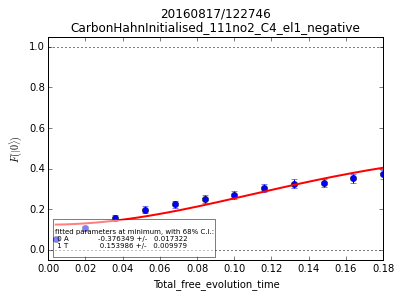

In [26]:
## reload(fits)
Result = fits.exp_sin(timestamp=  None, contains = '1_neg',
                      offset=[0.5], amplitude = [0.5], center = [0], decay_constant = [100e-3], 
                      exp_power = [2],
                      frequency = [0.], phase =[0], 
                      fixed = [0,2,4,5,6],
                      ylim = None,
                      plot_fit = True, do_print = True, show_guess = False)

###params
# 0 : offset
# 1 : amplitude
# 2 : center
# 3 : decay_constant
# 4 : exp_power
# 5 : frequency
# 6 : phase

In [ ]:
reload(fits)
Result = fits.exp_sin(timestamp=None, contains = '111no2',
                      offset=[0.5], amplitude = [0.76,0.75], center = [0]*2, decay_constant = [30]*2, exp_power = [2]*2,
                      frequency = [443393.29,416812.23], phase =[-179,-185],                       
                      fixed = [0,2,4],
                      ylim = None,
                      plot_fit = True, do_print = True, show_guess = False)

# fit param order for fixing
#0 offset[0], 1 amplitude[0], 2 decay_constant[0], 3 amplitude[0],
#4 frequency[0], 5 phase[0], 6 amplitude[1], 7 frequency[1], 8 phase[1])

# Compare Cr before and after

reloaded


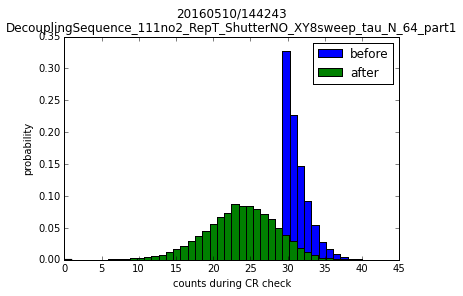

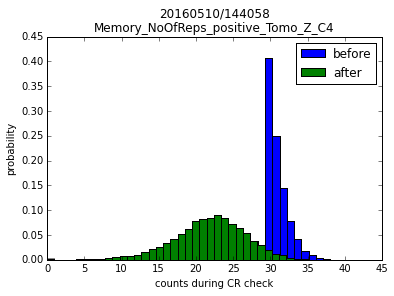

In [95]:
reload(fits)
fits.get_CR_histos(contains = '144243')
fits.get_CR_histos(contains = '144058')